In [ ]:
#@title Load Kaggle API Token
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download arstimgames/videodalle

# Install

In [ ]:
!pip install rudalle==0.0.1rc4

In [ ]:
!unzip /content/videodalle.zip

In [ ]:
!pip install transformers

# Video name

In [ ]:
video_name = '\u0422\u0430\u043D\u0446\u044B \u043D\u0430 \u043B\u044C\u0434\u0443'#@param {type:"string"}

# Make video

In [ ]:
import more_itertools
from tqdm.auto import tqdm
import torch
import transformers
from rudalle.pipelines import show, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_ruclip
from rudalle.utils import seed_everything, torch_tensors_to_pil_list

# prepare models:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
dalle.load_state_dict(torch.load('videodalle.pt'))

In [ ]:
tokenizer = get_tokenizer()
vae = get_vae()

# prepare utils:
#ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')

In [ ]:
def generate_video(text, tokenizer, dalle, top_k, top_p, temperature=1.0,
                    seed=None, num_frames=8):
    vocab_size = dalle.get_param('vocab_size')
    text_seq_length = dalle.get_param('text_seq_length')
    image_seq_length = dalle.get_param('image_seq_length')
    total_seq_length = dalle.get_param('total_seq_length')
    device = dalle.get_param('device')
    text = text.lower().strip()
    input_ids = tokenizer.encode_text(text, text_seq_length=text_seq_length)
    codebooks = []
    with torch.no_grad():
        attention_mask = torch.tril(torch.ones((1, 1, total_seq_length, total_seq_length), device=device))
        text_out = input_ids.unsqueeze(0).repeat(1, 1).to(device)
        has_cache = True
        use_cache = False
        image_out = None
        image_out_for_generate = None
        for idx in tqdm(range(256 * num_frames)):
            if image_out is None:
                logits, has_cache = dalle(text_out, attention_mask,
                                                  has_cache=has_cache, use_cache=use_cache, return_loss=False)
            else:
                inp = torch.cat((text_out, image_out_for_generate), dim=-1)
                logits, has_cache = dalle(inp, attention_mask,
                                                  has_cache=has_cache, use_cache=False, return_loss=False)
                        
            logits = logits[:, -1, vocab_size:]
            logits /= temperature
            filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
            probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
            sample = torch.multinomial(probs, 1)

            if image_out is None:
                has_cache, use_cache = True, True
                image_out = sample
                image_out_for_generate = sample
            else:
                has_cache, use_cache = True, True
                image_out = torch.cat((image_out, sample), dim=-1)
                image_out_for_generate = torch.cat((image_out_for_generate, sample), dim=-1)
            if image_out_for_generate is not None:
                if image_out_for_generate.shape[1] == 1024:
                    has_cache, use_cache = False, False
                    image_out_for_generate = image_out_for_generate[:, -768:]
    pil_images = []
    #for _codebooks in tqdm(torch.cat(image_out).cpu()):
    _codebooks = image_out.view(num_frames, 256).cpu()
    with torch.no_grad():
        images = vae.decode(_codebooks)
        pil_images += torch_tensors_to_pil_list(images)
    return pil_images

In [ ]:
text = video_name

seed_everything(6955)
pil_images = generate_video(text, tokenizer, dalle, top_k=1024, top_p=1, num_frames=16, temperature=0.96)

In [ ]:

import cv2
import numpy as np
import glob
 
img_array = []
for image_pil in pil_images:
    image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_BGR2RGB)
    height, width, layers = image_cv.shape
    size = (width,height)
    img_array.append(image_cv)
 
 
out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 5, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

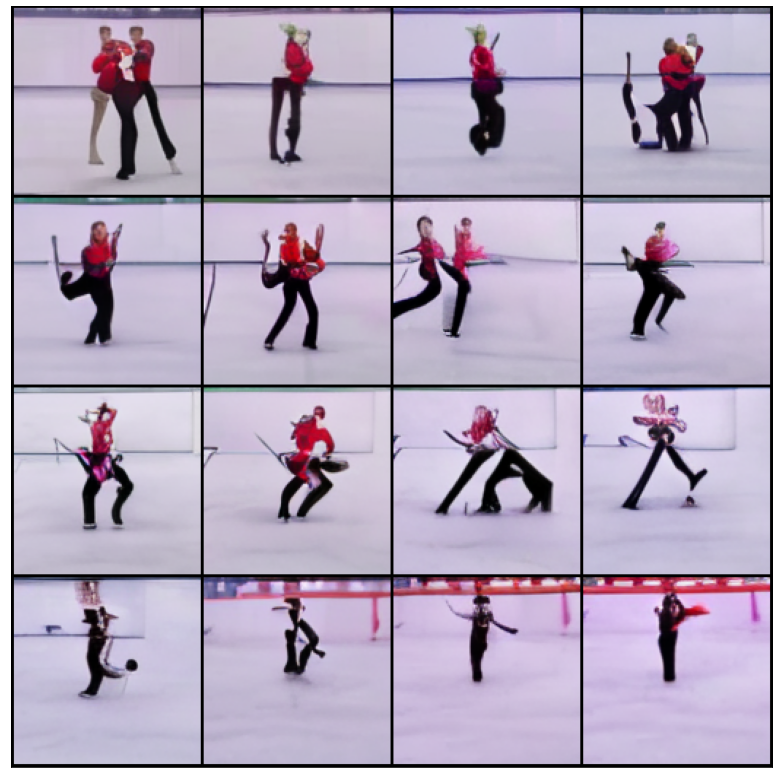

In [ ]:
show(pil_images, 4)

In [ ]:
!ffmpeg -i project.avi video.mp4